In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import nltk
nltk.download('punkt_tab') # Try this first, as the error explicitly asks for it.

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
import nltk

# Download necessary NLTK data (run these lines ONCE)
# You might get a pop-up window the first time, or it might download silently.
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/omw-1.4') # Often needed with wordnet
except LookupError:
    nltk.download('omw-1.4')

print("NLTK data check complete. Proceeding with the notebook.")

NLTK data check complete. Proceeding with the notebook.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Original Labels: ['positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive']
Encoded Labels: [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1)]
Label mapping: ['negative', 'positive'] -> [0 1]

Shape of X_train (TF-IDF features): (5, 32)
Shape of y_train (encoded labels): (5,)

--- Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673 (2.63 KB)

 Trainable params: 673 (2.63 KB)

 Non-trainable params: 0 (0.00 B)


--- Model Training ---
Model Training Finished.


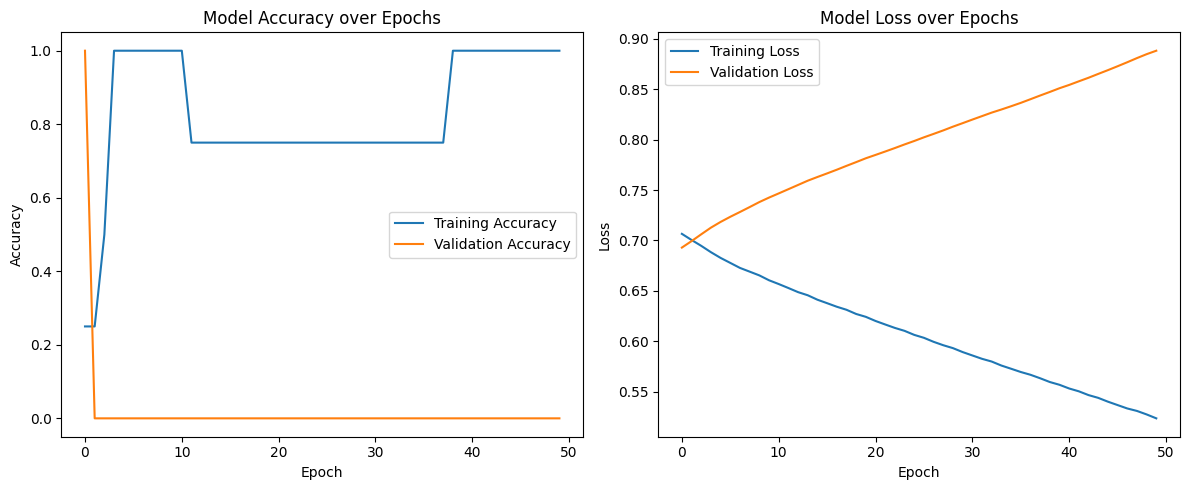

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam # Using Adam optimizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

# --- Preprocessing Function (from Day 8) ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return " ".join(lemmatized_tokens)

# --- Sample Dataset (from Day 10) ---
data = {
    'text': [
        "This movie is fantastic and I loved it!",
        "What a terrible film, absolutely hated it.",
        "The food was good, but the service was slow.",
        "Excellent experience, highly recommend.",
        "I regret wasting my time on this boring show.",
        "Happy with the purchase, great product.",
        "Worst customer service ever, very disappointed.",
        "A surprisingly good story, well written."
    ],
    'sentiment': [
        'positive', 'negative', 'negative', 'positive',
        'negative', 'positive', 'negative', 'positive'
    ]
}
df = pd.DataFrame(data)
df['processed_text'] = df['text'].apply(preprocess_text)

X = df['processed_text']
y = df['sentiment']

# --- Text Representation using TF-IDF ---
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray() # Convert to dense array for Keras

# --- Label Encoding for y ---
# Keras expects numerical labels for classification
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # 'negative' -> 0, 'positive' -> 1 (or vice versa depending on alphabetical order)
print(f"\nOriginal Labels: {list(y)}")
print(f"Encoded Labels: {list(y_encoded)}")
print(f"Label mapping: {list(label_encoder.classes_)} -> {label_encoder.transform(label_encoder.classes_)}")

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print(f"\nShape of X_train (TF-IDF features): {X_train.shape}")
print(f"Shape of y_train (encoded labels): {y_train.shape}")

# --- Build the Neural Network Model ---
# Input dimension should match the number of features (vocabulary size) from TF-IDF
input_dim = X_train.shape[1]

model = Sequential([
    Input(shape=(input_dim,)),  # Input Layer
    Dense(16, activation='relu'), # Hidden Layer 1 with 16 neurons and ReLU activation
    Dense(8, activation='relu'),  # Hidden Layer 2 with 8 neurons and ReLU activation
    Dense(1, activation='sigmoid') # Output Layer: 1 neuron for binary classification, sigmoid for probability
])

# 2. Compile the model
# optimizer: Adam is a popular choice for deep learning
# loss: 'binary_crossentropy' for binary classification
# metrics: 'accuracy' to track performance during training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print("\n--- Model Summary ---")
model.summary()

# 3. Train the model
# epochs: number of times the model will go through the entire training dataset
# batch_size: number of samples per gradient update
# validation_split: percentage of training data to use for validation during training
print("\n--- Model Training ---")
history = model.fit(X_train, y_train,
                    epochs=50,       # You can increase this for better learning, but for small data, it might overfit
                    batch_size=2,
                    validation_split=0.1, # Use a small validation split as our dataset is tiny
                    verbose=0) # Set to 1 to see training progress per epoch

print("Model Training Finished.")

# Optional: Plot training history (accuracy and loss over epochs)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()